In [16]:
# loading a pre-trained CVQVAE model and using it to encode images

import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

from models.cvqvae import CVQVAE



In [17]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 256
MODEL_PATH = "D:\cs4100\SnapRender\samples_64_full\\vqvae_without_mask.pth" 

model = CVQVAE(num_embeddings=512, embedding_dim=64).to(DEVICE) 
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

C:\Users\Qinmay\AppData\Local\Temp\ipykernel_25416\2419797314.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

CVQVAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (vq): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Sigmoid()
    )
  )
)

In [18]:
# Load the full image as RGB and the mask as grayscale
def load_full_and_mask(full_path, mask_path):
    full = Image.open(full_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # resize to target dimension
    transform = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
    ])

    # apply transformations to both images
    full_tensor = transform(full) # [3, H, W]
    mask_tensor = transform(mask).squeeze(0) # [H, W]

    # create a binary mask by thresholding the mask tensor
    binary_mask = (mask_tensor > 0.1).float()  # foreground mask

    return full_tensor.unsqueeze(0), binary_mask.unsqueeze(0)


In [ ]:
# extract background latent
# downsample the mask to match the latent size, helped by generated AI when debugging this function
def downsample_mask(mask, target_shape):
    # make sure the mask is 4D tensor
    if mask.ndim == 2:
        mask = mask.unsqueeze(0).unsqueeze(0)
    elif mask.ndim == 3:
        mask = mask.unsqueeze(0)
    return F.interpolate(mask, size=target_shape, mode='nearest')

def extract_background_latent(model, image, mask):
    with torch.no_grad():
        z_e = model.encoder(image) # get the encoder output
        z_q, _ = model.vq(z_e) # quantize the encoder output

        downsampled_mask = downsample_mask(mask, z_q.shape[2:]) # downsample the mask to match the latent size

        bg_mask = 1 - downsampled_mask # create the background mask
        masked_latent = z_q * bg_mask # apply the background mask to the latent space

        background_latent_features = masked_latent.sum(dim=(2, 3)) / (bg_mask.sum(dim=(2, 3)) + 1e-6) # compute the mean of the background latent features 
        
        return background_latent_features.squeeze(0).cpu().numpy() 

In [20]:
# debugging: check the model and device
from glob import glob
img_paths = sorted(glob("data/train/bg1k_imgs/*.png"))
print(img_paths[:5])

['data/train/bg1k_imgs\\0.png', 'data/train/bg1k_imgs\\1.png', 'data/train/bg1k_imgs\\10.png', 'data/train/bg1k_imgs\\100.png', 'data/train/bg1k_imgs\\101.png']


In [22]:
latents = []
paths = []

# loop through all parts
for part_id in range(5):
    img_paths = sorted(glob(f"data/train/bg60k_imgs_{part_id}/*.png"))

    # loop through all images in the directory
    for full_path in tqdm(img_paths, desc=f"Part {part_id}"):

        file_id = os.path.basename(full_path).replace(".png", "")
        mask_path = f"data/train/bg60k_masks_{part_id}/{file_id}_mask.png"

        if not os.path.exists(mask_path):
            continue
        
        # load the full image and mask
        full_tensor, mask_tensor = load_full_and_mask(full_path, mask_path)
        full_tensor = full_tensor.to(DEVICE)
        mask_tensor = mask_tensor.to(DEVICE)

        # extract the background latent
        latent = extract_background_latent(model, full_tensor, mask_tensor)
        latents.append(latent)
        paths.append(full_path)

if len(latents) == 0:
    raise ValueError("no background latent extracted, please check the paths")

# KMeans clustering
k = 6

kmeans = KMeans(n_clusters=k, random_state=42).fit(latents)
labels = kmeans.labels_


Part 0:   0%|          | 0/6330 [00:00<?, ?it/s]

Part 0:  13%|█▎        | 814/6330 [00:29<03:13, 28.54it/s]c:\Users\Qinmay\anaconda3\envs\py310_env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Part 3: 100%|██████████| 6329/6329 [00:00<00:00, 28075.92it/s]
Part 4: 0it [00:00, ?it/s]


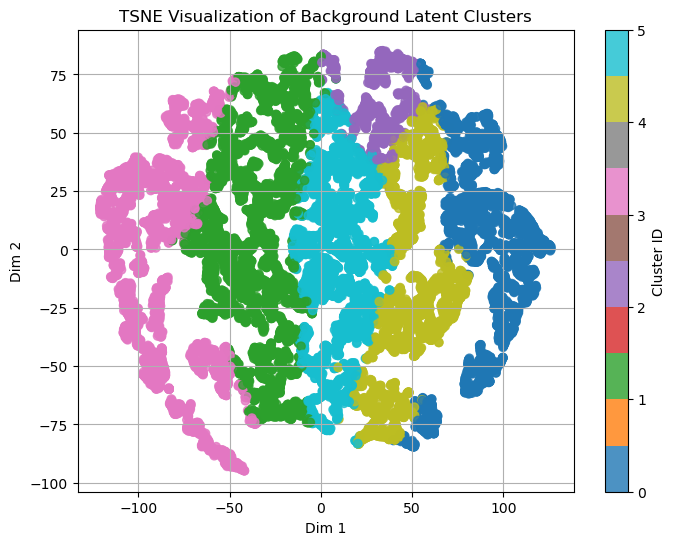

In [25]:
# visualize the clusters

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

method = 'tsne'
# define the dimensionality reduction method
reducer = TSNE(n_components=2, perplexity=30, random_state=42)

latents_np = np.array(latents) # transform to numpy array

# check the dimensionality reduction method
if method == 'tsne' and latents_np.shape[0] <= 30:
    raise ValueError(f"sample size {latents_np.shape[0]} is too small for t-SNE, please use PCA instead")

latent_2d = reducer.fit_transform(latents_np)# apply t-SNE to reduce the dimensionality to 2D

# draw 
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
plt.title(f"{method.upper()} Visualization of Background Latent Clusters")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(scatter, ticks=range(max(labels)+1), label='Cluster ID')
plt.grid(True)
plt.show()

In [26]:
# plot cluster images examples with masks
# helped by generated AI whe constructing this function
def plot_cluster_images_masked(paths, labels, cluster_id, mask_root, max_imgs=10):
    indices = [i for i, label in enumerate(labels) if label == cluster_id][:max_imgs]
    tensors = []

    for i in indices:
        full = Image.open(paths[i]).convert("RGB").resize((64, 64))

        file_id = os.path.basename(paths[i]).replace(".png", "")
        mask_path = os.path.join(mask_root, f"{file_id}_mask.png")
        if not os.path.exists(mask_path):
            continue

        # load mask and convert to tensor
        mask = Image.open(mask_path).convert("L").resize((64, 64))
        mask_tensor = T.ToTensor()(mask)
        mask_tensor = (mask_tensor > 0.1).float()  # 1=前景，0=背景

        # load full image and convert to tensor
        full_tensor = T.ToTensor()(full)

        # mask the foreground 
        gray = torch.ones_like(full_tensor) * 0.5
        bg_only = full_tensor * (1 - mask_tensor) + gray * mask_tensor

        tensors.append(bg_only)


    grid = vutils.make_grid(tensors, nrow=max_imgs)
    plt.figure(figsize=(max_imgs, 2))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Cluster {cluster_id} (Foreground Masked)")
    plt.axis("off")
    plt.show()


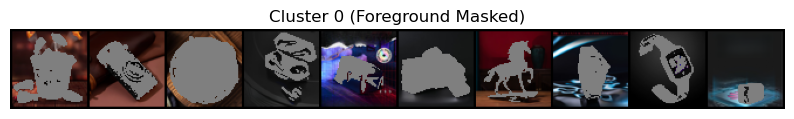

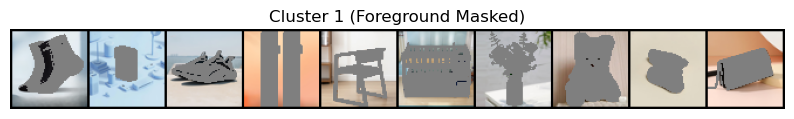

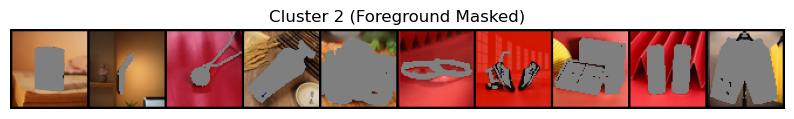

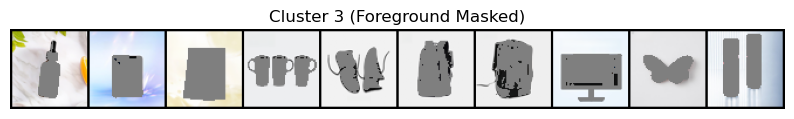

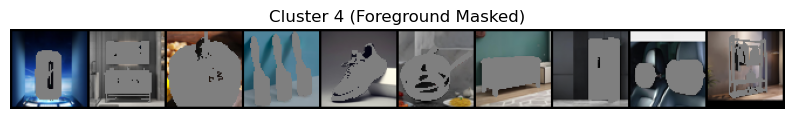

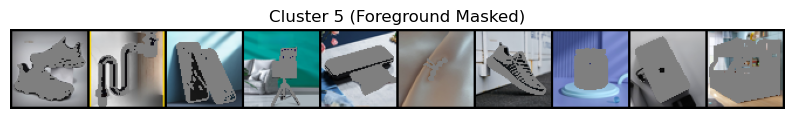

In [ ]:
mask_root = "data/train/bg60k_masks_0"

for cluster_id in range(k):
    plot_cluster_images_masked(paths, labels, cluster_id, mask_root)